In [1]:
import pandas as pd
import numpy as np
import sys
import os
import bs4
from IPython.display import display_html,clear_output, HTML
import re
from datetime import datetime
import ast
import itertools
from tqdm import tqdm,trange
from file_tools import *
from request_tools import *
from parse_tools import *
from load_tools import *
from model_tools import *
import pyarrow as pa

pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 30)
pd.set_option('compute.use_numexpr', False)

import warnings
from pandas.errors import PerformanceWarning
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
pd.options.mode.use_inf_as_na = True
warnings.filterwarnings('ignore', category=PerformanceWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

import pandas as pd
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, RFE, mutual_info_regression
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVR


In [7]:
SRC_DIR = './07-data-compiled/dataset-ss0110-mnmx-7fg'
FEATURES,LABELS = load_dataset(SRC_DIR)
FEATURES = FEATURES.dropna().iloc[:]
LABELS = LABELS.loc[FEATURES.index]['W/L']

FEATURES.shape,LABELS.shape

((19234, 346), (19234,))

In [8]:
X_train,X_test,y_train,y_test = train_test_split(FEATURES,LABELS,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((15387, 346), (3847, 346), (15387,), (3847,))

In [27]:
from sklearn.metrics import classification_report


model = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)
model.fit(X_train,y_train)
y_pred = pd.Series(model.predict(X_test),index=y_test.index)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.66      0.65      1904
           1       0.65      0.61      0.63      1943

    accuracy                           0.64      3847
   macro avg       0.64      0.64      0.64      3847
weighted avg       0.64      0.64      0.64      3847



In [55]:
from sklearn.ensemble import IsolationForest

# Assuming X_train contains your training features (excluding the "WL" outcome)
# You can adjust the contamination parameter based on the expected percentage of outliers
iso_forest_model = IsolationForest(contamination=0.5, random_state=42)

# Train the Isolation Forest model
iso_forest_model.fit(X_train)

# Predict anomaly scores for each instance in the dataset
anomaly_scores = pd.Series(iso_forest_model.decision_function(X_test),index=X_test.index)

# Set a threshold to classify instances with high anomaly scores as outliers
# threshold = -0.2
# outliers = X_train[anomaly_scores < threshold]

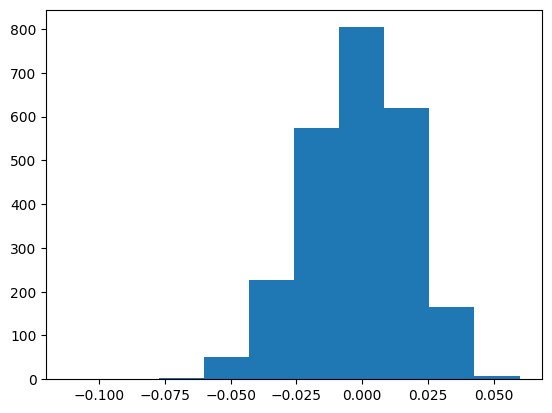

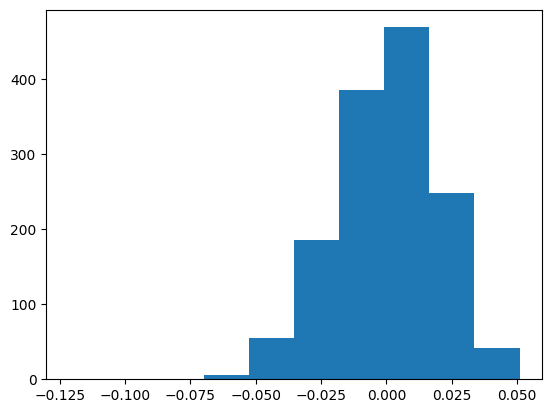

In [56]:
from matplotlib import pyplot as plt

y_pred_correct = y_pred[y_pred == y_test]
y_pred_incorrect = y_pred[y_pred != y_test]
anomaly_scores_correct = anomaly_scores.loc[y_pred_correct.index]
anomaly_scores_incorrect = anomaly_scores.loc[y_pred_incorrect.index]
plt.hist(anomaly_scores_correct)
plt.show()
plt.hist(anomaly_scores_incorrect) # This is the distribution of anomaly scores for incorrect predictions
plt.show()


In [57]:
# y_pred_correct = y_pred[y_pred == y_test]
# y_pred_incorrect = y_pred[y_pred != y_test]
# anomaly_scores_correct = anomaly_scores.loc[y_pred_correct.index]
# anomaly_scores_incorrect = anomaly_scores.loc[y_pred_incorrect.index]
# plt.hist(anomaly_scores_correct)
# plt.show()
# plt.hist(anomaly_scores_incorrect) # This is the distribution of anomaly scores for incorrect predictions
# plt.show()
threshold = 0
anomaly_scores_inliers = anomaly_scores[anomaly_scores >= threshold]
anomaly_scores_outliers = anomaly_scores[anomaly_scores < threshold]
y_pred_inliers = y_pred[anomaly_scores >= threshold]
y_pred_outliers = y_pred[anomaly_scores < threshold]
print(classification_report(y_test[anomaly_scores >= threshold],y_pred_inliers))
print(classification_report(y_test[anomaly_scores < threshold],y_pred_outliers))

              precision    recall  f1-score   support

           0       0.61      0.64      0.63       969
           1       0.63      0.60      0.61       972

    accuracy                           0.62      1941
   macro avg       0.62      0.62      0.62      1941
weighted avg       0.62      0.62      0.62      1941

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       935
           1       0.68      0.63      0.65       971

    accuracy                           0.66      1906
   macro avg       0.66      0.66      0.66      1906
weighted avg       0.66      0.66      0.66      1906



In [11]:
anomaly_scores

# Now 'outliers' contains instances identified as potential outliers


array([0.05259627, 0.03640196, 0.05417717, ..., 0.03804217, 0.02531061,
       0.04139683])